# US Housing Market Analysis

In [14]:
#import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from kaleido.scopes.plotly import PlotlyScope
from bokeh.io import export_png
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Loading and cleaning data
We will be using data from [FRED](https://fred.stlouisfed.org/), the Federal Reserve Economic Data. This data was selected based on the previous analysis of the housing market, but some of the data was only available in quarterly or annual intervals. The decision was made to use the monthly data and aggregate it to the quarterly and annual levels in some cases, and to remove the feature in one case. The feature removed was 'Interest Rate' as it was not available at the monthly level and showed little importance in the previous analysis.

In [2]:
# Read in data
file_path = Path("data/housing_data.csv")
df = pd.read_csv(file_path)
df.head()

,Date,Price Index,New Inv,GDP,30-Year Rate Avg,Monthly Supply,Median Price,Permits,Construction Spending,Sentiment Index
0,2002-01-01,116.437,14342,10783.50,6.9975,4.2,188700.0,1665.0,382979,93.0
1,2002-02-01,116.916,14342,10783.50,6.8925,4.0,188700.0,1787.0,391434,90.7
2,2002-03-01,117.929,14342,10783.50,7.0140,4.1,188700.0,1691.0,390942,95.7
3,2002-04-01,119.208,14207,10887.46,6.9850,4.3,187200.0,1669.0,404255,93.0
4,2002-05-01,120.787,14207,10887.46,6.8060,4.0,187200.0,1716.0,399164,96.9


In [3]:
df.tail()

,Date,Price Index,New Inv,GDP,30-Year Rate Avg,Monthly Supply,Median Price,Permits,Construction Spending,Sentiment Index
248,2022-09-01,300.451,15306,25723.941,6.1120,9.7,468000.0,1588.0,889018,58.6
249,2022-10-01,298.672,14554,26137.992,6.9000,9.7,479500.0,1555.0,874105,59.9
250,2022-11-01,296.809,14554,26137.992,6.8050,9.4,479500.0,1402.0,869322,56.8
251,2022-12-01,294.266,14554,26137.992,6.3640,8.5,479500.0,1409.0,868435,59.7
252,2023-01-01,292.444,15053,26486.287,6.2725,8.1,436800.0,1354.0,851235,64.9


In [4]:
# create a new column called 'PRICE_CHANGE_UP_DOWN' and set the values to 0 if the value of the 'CSUSHPISA' column is less than the value of the previous row, otherwise set the value to 1
df["Price Change"] = np.where(df["Price Index"] < df["Price Index"].shift(1), 0, 1)
df.tail(10)

,Date,Price Index,New Inv,GDP,30-Year Rate Avg,Monthly Supply,Median Price,Permits,Construction Spending,Sentiment Index,Price Change
243,2022-04-01,301.789,15286,25248.476,4.9825,8.5,449300.0,1795.0,940598,65.2,1
244,2022-05-01,306.569,15286,25248.476,5.2300,8.3,449300.0,1708.0,954475,58.4,1
245,2022-06-01,308.334,15286,25248.476,5.5220,9.5,449300.0,1701.0,946828,50.0,1
246,2022-07-01,307.135,15306,25723.941,5.4125,10.1,468000.0,1658.0,936964,51.5,0
247,2022-08-01,303.649,15306,25723.941,5.2225,8.7,468000.0,1586.0,905056,58.2,0
248,2022-09-01,300.451,15306,25723.941,6.1120,9.7,468000.0,1588.0,889018,58.6,0
249,2022-10-01,298.672,14554,26137.992,6.9000,9.7,479500.0,1555.0,874105,59.9,0
250,2022-11-01,296.809,14554,26137.992,6.8050,9.4,479500.0,1402.0,869322,56.8,0
251,2022-12-01,294.266,14554,26137.992,6.3640,8.5,479500.0,1409.0,868435,59.7,0
252,2023-01-01,292.444,15053,26486.287,6.2725,8.1,436800.0,1354.0,851235,64.9,0


In [5]:
# get the value counts for the PRICE_CHANGE_UP_DOWN column
df["Price Change"].value_counts()

1    174
0     79
Name: Price Change, dtype: int64

# Defining the feature and target variables

In [6]:
# Define features set
X = df.copy()
X = X.drop("Date", axis=1)
X = X.drop("Price Index", axis=1)
X = X.drop("Price Change", axis=1)
# drop first row
X = X.iloc[1:]
X.head()

,New Inv,GDP,30-Year Rate Avg,Monthly Supply,Median Price,Permits,Construction Spending,Sentiment Index
1,14342,10783.50,6.8925,4.0,188700.0,1787.0,391434,90.7
2,14342,10783.50,7.0140,4.1,188700.0,1691.0,390942,95.7
3,14207,10887.46,6.9850,4.3,187200.0,1669.0,404255,93.0
4,14207,10887.46,6.8060,4.0,187200.0,1716.0,399164,96.9
5,14207,10887.46,6.6500,4.2,187200.0,1758.0,407305,92.4


In [7]:
# checking the shape of X and if there are any null values
print(X.shape)
print(X.isnull().sum())

(252, 8)
New Inv                  0
GDP                      0
30-Year Rate Avg         0
Monthly Supply           0
Median Price             0
Permits                  0
Construction Spending    0
Sentiment Index          0
dtype: int64


# Creating the target vector 
Price Index = S&P/Case-Shiller U.S. National Home Price Index (Index Jan 2000=100, Seasonally Adjusted)

In [8]:
# Define target vector 'Price Change' as y
y = df["Price Index"].values.reshape(-1, 1)
y = y[1:]
y[:5]

array([[116.916],
       [117.929],
       [119.208],
       [120.787],
       [122.333]])

# Splitting the data into training and testing sets

In [9]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)


In [10]:
# Create a StandardScaler instance
scaler = StandardScaler()

In [11]:
# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

In [12]:
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_test_scaled.shape

(63, 8)

# Fitting the Random Forest model

Having scaled the data, we can now fit the Random Forest model to the training data.

In [15]:
# create the random forrest regressor instance
rf_model = RandomForestRegressor(n_estimators=500, random_state=78)
# fit the model
rf_model = rf_model.fit(X_train_scaled, y_train.ravel())

# Making predictions with the Random Forest model

In [16]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)
predictions

array([204.84358 , 304.867256, 159.743884, 145.733932, 170.656128,
       135.320206, 175.232278, 195.418608, 195.086762, 149.056678,
       146.928982, 121.76301 , 124.632   , 208.801526, 161.345214,
       168.067196, 146.074226, 207.093882, 179.815584, 182.549382,
       120.670198, 212.416594, 289.075528, 296.694136, 181.06201 ,
       205.055554, 143.047086, 240.068692, 146.654586, 210.954606,
       174.703174, 151.466458, 132.120708, 183.298366, 184.81277 ,
       172.149848, 137.5299  , 223.108458, 156.265668, 202.173528,
       236.235064, 271.71592 , 142.940808, 181.85752 , 127.160634,
       176.221502, 179.800682, 140.026886, 166.155166, 139.363514,
       175.35731 , 183.30399 , 181.974242, 144.327578, 210.790282,
       140.464004, 141.004128, 182.384338, 147.490606, 173.712956,
       167.748708, 205.172772, 301.812548])

In [17]:
# compare predictions to actual values
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")


First 10 Predictions:   [204.84358  304.867256 159.743884 145.733932 170.656128 135.320206
 175.232278 195.418608 195.086762 149.056678]
First 10 Actual labels: [[205.34], [308.334], [159.55700000000004], [145.003], [171.85], [137.076], [175.923], [194.357], [193.52200000000002], [149.362]]


# Evaluating the Random Forest model

In [18]:
# chart of predictions vs actual
results_df = pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()})
# change the datatypes to float
results_df = results_df.astype("float64")
# add a column for the difference between the prediction and actual
results_df["Difference"] = results_df["Actual"] - results_df["Prediction"]
# add a column for the percent difference between the prediction and actual
results_df["Percent Difference"] = results_df["Difference"] / results_df["Actual"] * 100
# find the highest percent difference
results_df["Percent Difference"].max()
results_df.head(10)

,Prediction,Actual,Difference,Percent Difference
0,204.843580,205.340,0.496420,0.241755
1,304.867256,308.334,3.466744,1.124347
2,159.743884,159.557,-0.186884,-0.117127
3,145.733932,145.003,-0.730932,-0.504081
4,170.656128,171.850,1.193872,0.694717
5,135.320206,137.076,1.755794,1.280891
6,175.232278,175.923,0.690722,0.392627
7,195.418608,194.357,-1.061608,-0.546215
8,195.086762,193.522,-1.564762,-0.808571
9,149.056678,149.362,0.305322,0.204417


In [32]:
# use plotly express to create a histogram of the percent difference
fig = px.histogram(results_df, x="Percent Difference", title="Percent Difference Between Prediction and Actual")
fig.show()

In [33]:
# save the plot as a png file
scope = PlotlyScope()
with open("images/percent_difference_monthly.png", "wb") as f:
    f.write(scope.transform(fig, format="png"))

In [19]:
# calculate the mean absolute error (MAE)
mae = results_df["Difference"].mean()
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 0.5808200000001665


In [20]:
# calculate the mean squared error (MSE)
mse = results_df["Difference"].apply(lambda x: x**2).mean()
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 4.119908282158325


In [21]:
# calculate the root mean squared error (RMSE)
rmse = mse**(0.5)
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 2.0297557198240197


In [22]:
# calculate the mean absolute percent error (MAPE)
mape = results_df["Percent Difference"].abs().mean()
print(f"Mean Absolute Percent Error: {mape}")


Mean Absolute Percent Error: 0.7325020591178631


In [31]:
# score the model
rf_model.score(X_test_scaled, y_test)

0.9978779282181336

# Feature importance

In [24]:
# get the feature importance array
importances = rf_model.feature_importances_
# list of features
feature_list = list(X.columns)
# sort the features by their importance
sorted(zip(rf_model.feature_importances_, feature_list), reverse=True)
# print the feature importance
for feature in zip(feature_list, rf_model.feature_importances_):
    print(f"{feature[0]}: ({feature[1]})")
    

New Inv: (0.007942371574052502)
GDP: (0.5124434689924581)
30-Year Rate Avg: (0.01121063056453052)
Monthly Supply: (0.0043202114710724285)
Median Price: (0.24213733730381)
Permits: (0.003827051783971111)
Construction Spending: (0.2117094275890505)
Sentiment Index: (0.006409500721054741)


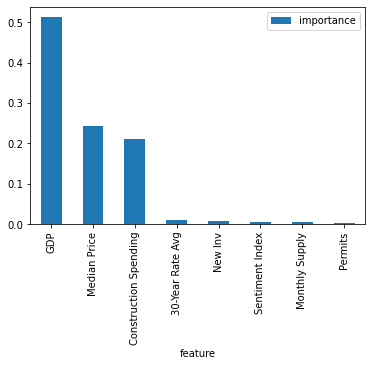

In [25]:
# add the feature importance to a dataframe
feature_importance_df = pd.DataFrame({"feature": feature_list, "importance": importances})
# sort the dataframe by the importance
feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)
# set the index to be the feature
feature_importance_df = feature_importance_df.set_index("feature", drop=True)
# plot the feature importance
feature_importance_df.plot(kind="bar")
plt.show()

In [26]:
# use plotly to create a bar chart of the feature importance
fig = px.bar(feature_importance_df, x=feature_importance_df.index, y="importance", color="importance", color_continuous_scale=px.colors.sequential.Cividis_r)
# set the title
fig.update_layout(title_text="Feature Importance")
# save the graph
fig.write_image("images/feature_importance_monthly.png")
fig.show()

In [29]:
# save a table of the feature importance
def save_df_as_image(df, filename):
    source = ColumnDataSource(df)
    columns = [TableColumn(field=Ci, title=Ci) for Ci in df.columns]  # bokeh columns
    # add index column
    columns.insert(0, TableColumn(field="index", title="index"))
    # use df index as index column
    source.add(df.index, "index")
    data_table = DataTable(columns=columns, source=source, width=800, height=280)
    export_png(data_table, filename=filename)
    
save_df_as_image(feature_importance_df, "images/feature_importance_monthly_table.png")